In [1]:
"""
importing examples 
├── project (package)
│   ├── src (package)
│   │   ├── __init__.py
│   │   └── utils.py
│   |── clustering.ipynb
    └── __init__.py

import src ---> src.utils.test(10)
from src import utils ---> utils.test(10)
from src.utils import test ---> test(10) 
----------------------------------------
please import each library in its own line 
e.g.

((THIS IS TRUE))
import os
import sys

((THIS IS WRONG))
import os,sys

----------------------------------------
in the package case its ok to import all things in one liune
e.g. 
from src import utils,constants   ((Thats OK !!))
----------------------------------------
import proiority : (very important)
1) Standard library imprts  e.g. sys,os
2) Third party imports e.g. pandas , numpy
3) Local imports e.g. utils , constants and other things inside the project
"""


'\nimporting examples \n├── project (package)\n│   ├── src (package)\n│   │   ├── __init__.py\n│   │   └── utils.py\n│   |── clustering.ipynb\n    └── __init__.py\n\nimport src ---> src.utils.test(10)\nfrom src import utils ---> utils.test(10)\nfrom src.utils import test ---> test(10) \n----------------------------------------\nplease import each library in its own line \ne.g.\n\n((THIS IS TRUE))\nimport os\nimport sys\n\n((THIS IS WRONG))\nimport os,sys\n\n----------------------------------------\nin the package case its ok to import all things in one liune\ne.g. \nfrom src import utils,constants   ((Thats OK !!))\n----------------------------------------\nimport proiority : (very important)\n1) Standard library imprts  e.g. sys,os\n2) Third party imports e.g. pandas , numpy\n3) Local imports e.g. utils , constants and other things inside the project\n'

In [2]:
# Third party Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Local imports
from src.utils import count_plot_percentage

In [3]:
data = pd.read_csv("data/Citywide_Mobility_Survey_-_Person_Survey_2019.csv")

In [4]:
data.head()

,hh_id,weight,cms_zone,survey_mode,person_id,person_num,is_participant,num_days,num_days_complete,num_trips,...,race_native_hawaiian,race_white,race_other,disability_hearing,disability_seeing,disability_walking,disability_mobility,disability_dressing,disability_concentrating,disability_none
0,191546322,0.00000,Inner Brooklyn,1,19154632203,3,0,NaN,NaN,NaN,...,995,995,995,995,995,995,995,995,995,995
1,191546322,0.00000,Inner Brooklyn,1,19154632202,2,0,NaN,NaN,NaN,...,995,995,995,995,995,995,995,995,995,995
2,191546322,212.12729,Inner Brooklyn,1,19154632201,1,1,7.0,7.0,23.0,...,1,0,0,0,0,0,0,0,0,1
3,19241657,0.00000,Middle Queens,1,1924165703,3,0,NaN,NaN,NaN,...,995,995,995,995,995,995,995,995,995,995
4,19241657,0.00000,Middle Queens,1,1924165702,2,0,NaN,NaN,NaN,...,995,995,995,995,995,995,995,995,995,995


* Observe having nominal data(categoricals represented by numbers). s.t. is_participant, race, and disability columns
* Observe having NULL values

In [5]:
# 'harassment', 'cms_zone'
data.drop(columns=['hh_id', 'weight', 'survey_mode', 'person_id', 'person_num',
       'is_participant', 'num_days', 'num_days_complete', 'num_trips',
       'num_walk_trips', 'num_transit_trips', 'num_bike_trips',
       'num_taxi_trips', 'num_tnc_trips', 'num_complete_weekend_days',
       'num_complete_weekdays', 'first_travel_date', 'last_travel_date',
       'made_trips', 'smartphone_type', 'relationship', 'age','student','license','vehicle',
       'school_type', 'school_cms_zone',
       'missing_school_location', 'kid_accompany', 'school_mode',
       'school_mode_own', 'school_park_location', 'school_vehicle_pass_period',
       'school_park_amount_day', 'school_park_amount_month',
       'school_park_amount_week', 'school_park_amount_year',
       'school_mode_auto', 'school_mode_bus', 'school_mode_rail',
       'school_mode_ferry', 'school_access', 'school_egress',
       'school_mode_taxi', 'school_mode_bike', 'school_bike_park',
       'school_mode_scooter', 'school_scooter_park', 'packages',
       'packages_distance', 'harassment_trip', 'harassment_time',
       'harassment_route', 'harassment_transit', 'harassment_mode',
       'harassment_neighborhood', 'harassment_private_car', 'harassment_alone',
       'harassment_attention', 'harassment_defense', 'harassment_other',
       'harassment_none', 'gender', 'education', 'english_proficiency',
       'ethnicity', 'race_american_indian', 'race_asian', 'race_black',
       'race_native_hawaiian', 'race_white', 'race_other',
       'disability_hearing', 'disability_seeing', 'disability_walking',
       'disability_mobility', 'disability_dressing',
       'disability_concentrating', 'disability_none'], inplace=True)

In [6]:
data.shape

(8286, 86)

In [7]:
data.describe()

,employment,worker,congestion,drive_cbd_freq,planning_apps,job_type,jobs_count,industry,telework_freq,missing_work_location,...,tnc_mode_ferry,tnc_mode_bike,tnc_mode_scooter,car_share_zipcar,car_share_car2go,car_share_enterprise,car_share_other,car_share_none,car_share_user,harassment
count,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,...,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000
mean,179.318972,177.439416,427.818489,704.796524,312.392711,693.674632,693.606445,695.968622,741.564808,0.024378,...,994.040309,993.700821,994.777939,483.426382,483.412744,483.408038,483.424813,483.744388,483.455588,310.883056
std,379.302123,380.170664,1439.534122,1082.444991,1820.980475,638.459567,638.533467,635.983702,431.696108,0.154230,...,29.105358,35.652814,14.292400,1206.031764,1206.037225,1206.039110,1206.032392,1205.904362,1206.020067,1824.547127
min,1.000000,0.000000,-9998.000000,-9998.000000,-9998.000000,-9998.000000,-9998.000000,-9998.000000,1.000000,0.000000,...,111.000000,2.000000,73.000000,-9998.000000,-9998.000000,-9998.000000,-9998.000000,-9998.000000,-9998.000000,-9998.000000
25%,1.000000,0.000000,4.000000,995.000000,4.000000,2.000000,2.000000,17.000000,8.000000,0.000000,...,995.000000,995.000000,995.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.000000
50%,3.000000,1.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,0.000000,...,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000
75%,6.000000,1.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,0.000000,...,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000
max,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,1.000000,...,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000


Though most of the features are nominal, but observe for quantitative data(jobs_count for example) that missing values, e.g., -9998 and 995, are affecting the results

In [8]:
# information about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8286 entries, 0 to 8285
Data columns (total 86 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cms_zone                     8286 non-null   object 
 1   employment                   8286 non-null   int64  
 2   worker                       8286 non-null   int64  
 3   congestion                   8286 non-null   int64  
 4   drive_cbd_freq               8286 non-null   int64  
 5   planning_apps                8286 non-null   int64  
 6   job_type                     8286 non-null   int64  
 7   jobs_count                   8286 non-null   int64  
 8   industry                     8286 non-null   int64  
 9   telework_freq                8286 non-null   int64  
 10  work_cms_zone                1687 non-null   object 
 11  missing_work_location        8286 non-null   int64  
 12  work_mode                    8286 non-null   int64  
 13  work_mode_own     

* Observe most of the values for 'work_park_amount_day', 'work_park_amount_week', 'work_park_amount_month' features are NULL
* and 'work_cms_zone' have more than 60% NULLs
* Observe 3 data types, will detect if we have more than these 3

In [ ]:
print(data['work_cms_zone'].isna().sum())
data['work_cms_zone'].isna().mean()

6599


0.7964035722906107

In [51]:
data.dtypes.unique()

array([dtype('O'), dtype('int64'), dtype('float64')], dtype=object)

* Observe having 'O' datatype, let's detect it

In [59]:
# get the columns with 'object' data type
# object_cols = data.select_dtypes(include=['object']).columns
data.select_dtypes(include=['O']).columns

Index(['cms_zone', 'work_cms_zone'], dtype='object')

It denotes 'object' data type

In [60]:
# Detect columns with 'object' data type
data.select_dtypes(include=['object']).columns

Index(['cms_zone', 'work_cms_zone'], dtype='object')

Same columns with 'O' data type

In [65]:
data.isna().mean().sort_values()

cms_zone                       0.000000
no_bike_share_uncomfortable    0.000000
no_bike_share_docks            0.000000
no_bike_share_personal_bike    0.000000
no_bike_share_stations         0.000000
                                 ...   
work_cms_zone                  0.796404
work_park_amount_day           0.997104
work_park_amount_month         0.997345
work_park_amount_week          0.998552
work_park_amount_year          0.999517
Length: 86, dtype: float64

In [10]:
categorical_data = data.select_dtypes(['object'])
categorical_data

,cms_zone,work_cms_zone
0,Inner Brooklyn,NaN
1,Inner Brooklyn,NaN
2,Inner Brooklyn,NaN
3,Middle Queens,NaN
4,Middle Queens,NaN
...,...,...
8281,Staten Island,NaN
8282,Staten Island,Staten Island
8283,Staten Island,NaN
8284,Staten Island,NaN


In [11]:
data['cms_zone'].value_counts()

Northern Bronx        1032
Staten Island         1024
Outer Queens           975
Southern Bronx         902
Middle Queens          835
Outer Brooklyn         822
Inner Brooklyn         767
Inner Queens           730
Northern Manhattan     657
Manhattan Core         542
Name: cms_zone, dtype: int64

In [12]:
print(data['work_cms_zone'].value_counts().sum())
data['work_cms_zone'].value_counts()

1687


Manhattan Core     815
Inner Brooklyn     166
Southern Bronx     122
Upper Manhattan    114
Outer Brooklyn      96
Inner Queens        79
Middle Queens       75
Staten Island       73
Northern Bronx      70
Outer Queens        69
JFK                  7
LGA                  1
Name: work_cms_zone, dtype: int64

In [13]:
set(data['cms_zone']) - set(data['work_cms_zone'])

{'Northern Manhattan'}

In [14]:
set(data['work_cms_zone']) - set(data['cms_zone'])

{'JFK', 'LGA', 'Upper Manhattan', nan}

'work_cms_zone' include more places than 'cms_zone'. e.g., 'JFK', 'LGA' airports

### Employment
* Detect employment status for majority of people
* Detect employment status relationship with transportation method used

In [17]:
data["employment"].value_counts()

1      3293
6      2185
995    1473
2       762
3       434
7       139
Name: employment, dtype: int64

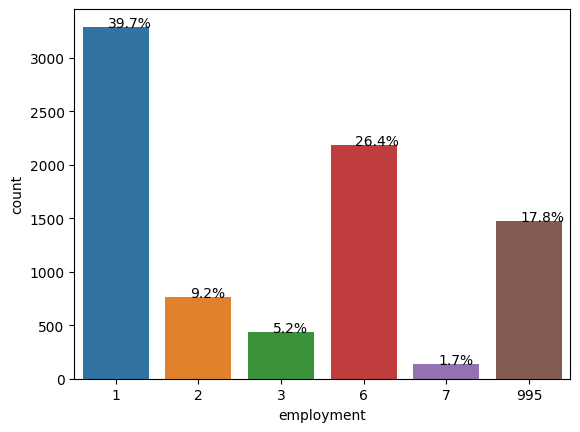

In [18]:
count_plot_percentage(data, 'employment')

* Most of the people are full-time paid employees
* Quarter of people aren't currently employed (e.g., retired, looking for work)
* Very few of people are volunteers or interns

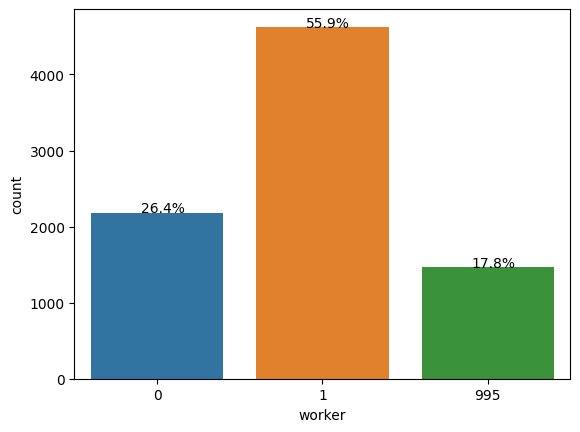

In [19]:
count_plot_percentage(data, 'worker')

* 55.9% of people are employed. Almost the half
* almost quarter of people aren't employed

In [20]:
data['jobs_count'].value_counts()

 995     5924
 1       2031
 2        231
 3         57
 6         17
-9998      15
 4          8
 5          3
Name: jobs_count, dtype: int64

In [21]:
data['job_type'].value_counts()

 995     5924
 1       1627
 2        497
 3        135
 4         88
-9998      15
Name: job_type, dtype: int64

Most usual work location for people is **one** work location, regardless of being a telework or onsite

In [22]:
data['industry'].value_counts().sort_values()

 3          3
 6         13
-9998      15
 11        28
 13        43
 2         60
 17        60
 5         87
 12        91
 9        100
 15       124
 10       128
 16       129
 14       167
 1        211
 4        221
 18       247
 7        298
 8        337
 995     5924
Name: industry, dtype: int64

* Most of them Missing: Skip logic
* Only 3 of them their work industry is: Capital goods (aerospace & defense, electrical, machinery)
* Most work industry in which people work in is: Health care/social assistance

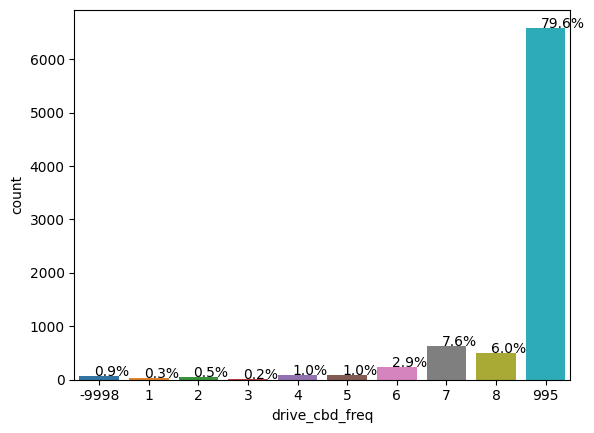

In [23]:
count_plot_percentage(data, 'drive_cbd_freq')

Regardless of 995(Missing: Skip logic), The majority of people who filled out the survey are those with least Frequency of driving vehicle into or within the area of Manhattan south of 60th Street

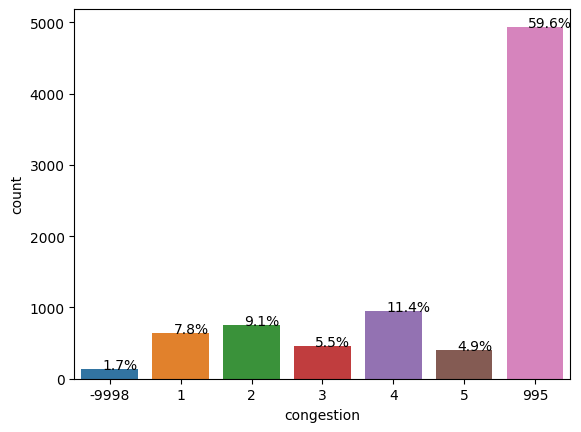

In [24]:
count_plot_percentage(data, 'congestion')

Proportion of people opposing and supporting the congistion almost equal

<AxesSubplot: xlabel='congestion', ylabel='count'>

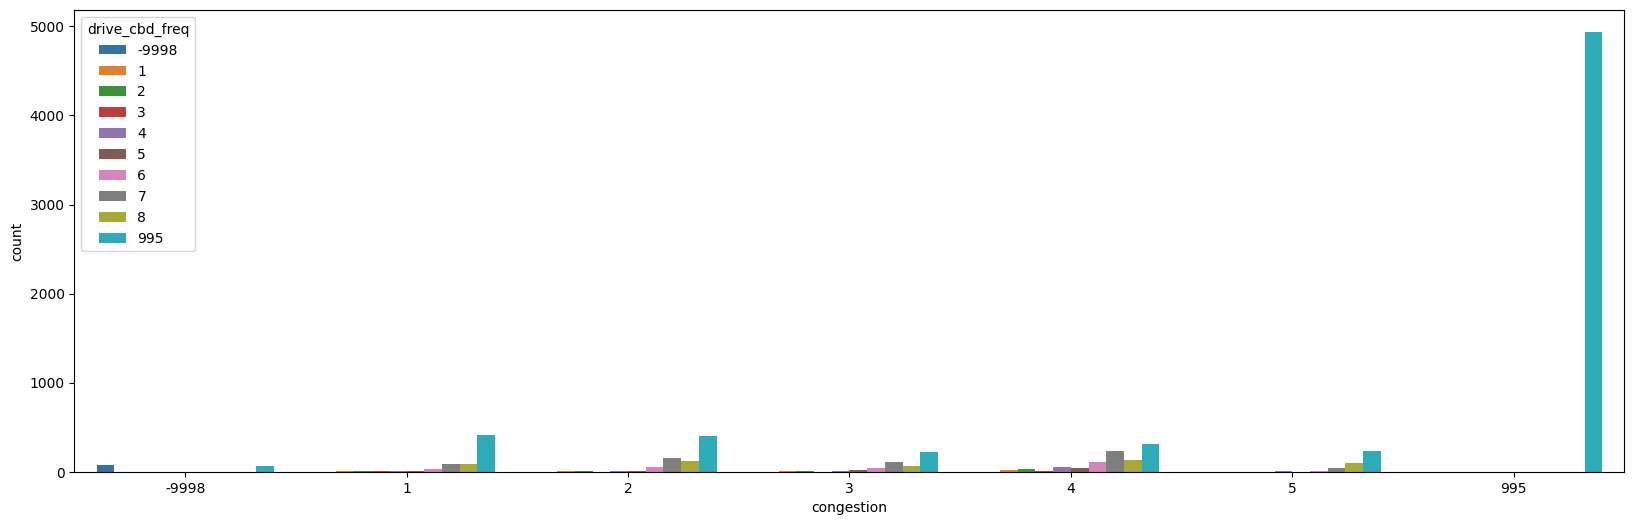

In [25]:
# Observe wheter people's frequency of driving vehicle into or within the area of Manhattan south of 60th Street affects supporting/opposing congesiton
plt.figure(figsize=(20, 6))
sns.countplot(x='congestion', hue='drive_cbd_freq', data=data)

No clear inferences, sounds that people who have never drived into or within Manhattan have alost equal voting with regard to congestion

In [26]:
data.groupby("congestion")["drive_cbd_freq"].value_counts()

congestion  drive_cbd_freq
-9998       -9998               73
             995                65
 1           995               413
             7                  87
             8                  86
             6                  30
             4                   8
             5                   8
             2                   7
             1                   3
             3                   3
 2           995               405
             7                 150
             8                 118
             6                  50
             5                  11
             4                  10
             2                   7
             1                   4
             3                   1
 3           995               218
             7                 107
             8                  61
             6                  37
             5                  19
             4                   9
             1                   3
             2              

Expect that people with more telework frequency support congestion and vice versa, let's detect that

<AxesSubplot: xlabel='telework_freq', ylabel='count'>

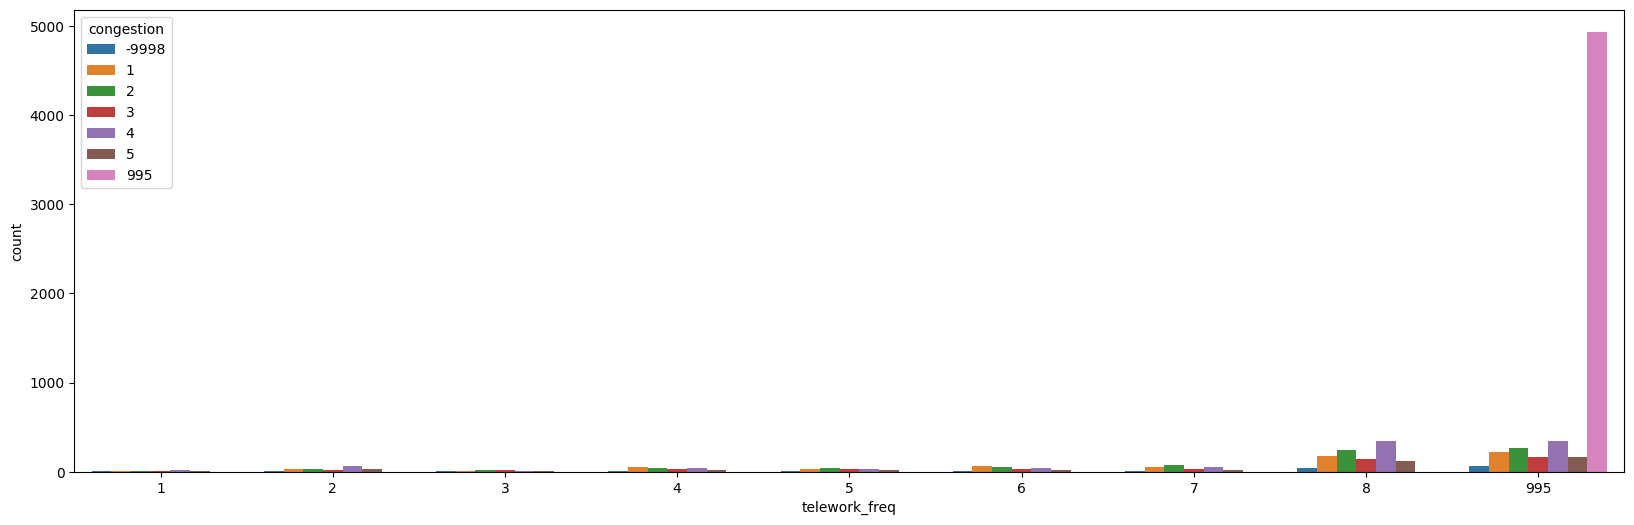

In [27]:
plt.figure(figsize=(20, 6))
sns.countplot(x='telework_freq', hue='congestion', data=data)

besides missing(skip logic), the majority voting is from people with no telework. Appear that most of them highly opposing congestion

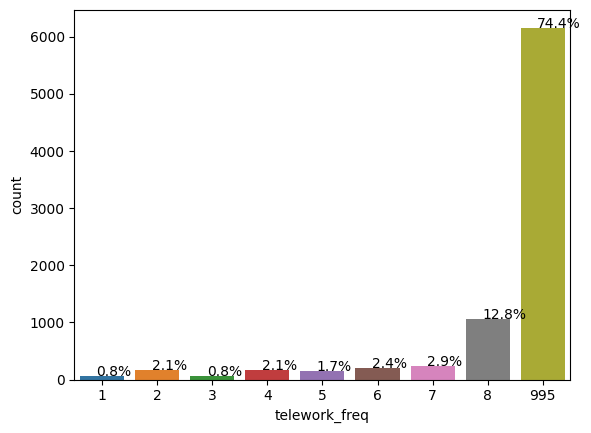

In [67]:
count_plot_percentage(data, 'telework_freq')

As detected from previous plot, majority of them are those with no telework, and missing(skip logic)

In [71]:
data['bike_num_days'].value_counts()

995    7007
0      1090
1        68
2        37
3        30
4        17
5        15
6        12
7        10
Name: bike_num_days, dtype: int64

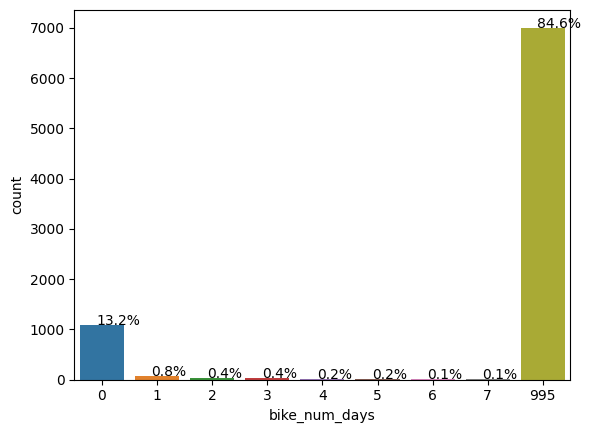

In [28]:
count_plot_percentage(data, 'bike_num_days')

Most of people don't ride a bike The whole week

<AxesSubplot: xlabel='bike_num_days', ylabel='count'>

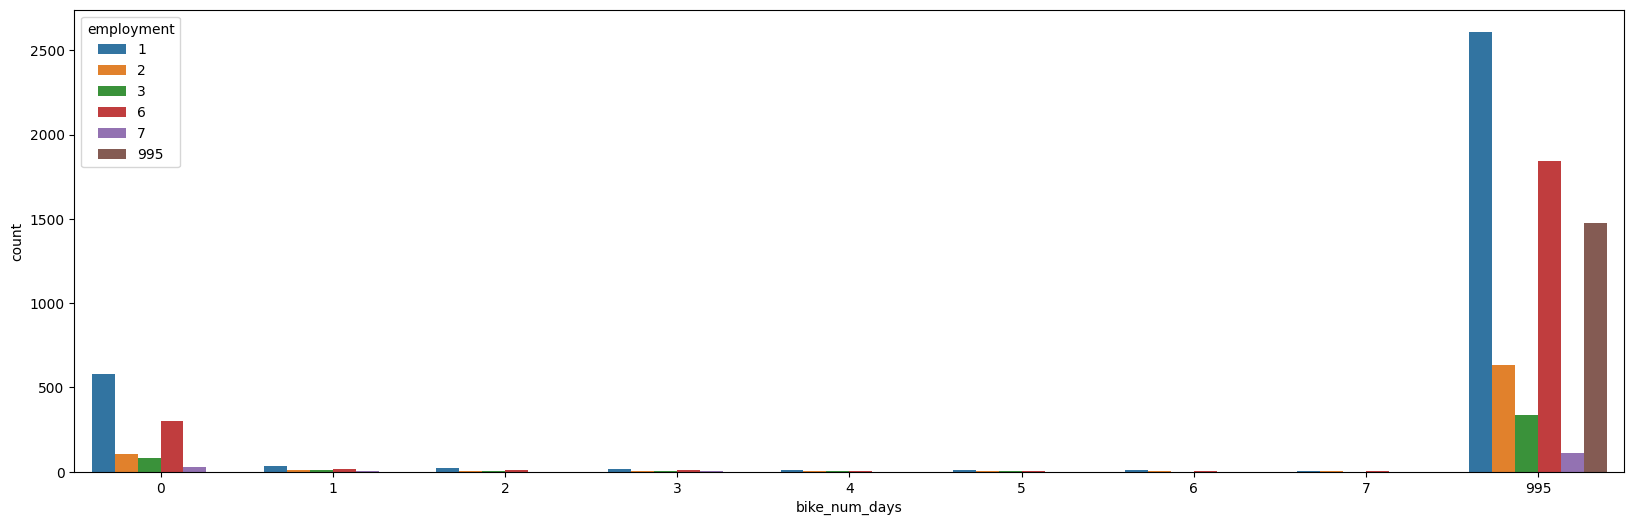

In [29]:
# Detect Bike && unemployed
plt.figure(figsize=(20, 6))
sns.countplot(x='bike_num_days', hue='employment', data=data)